#  Mushroom Image Classifier using TensorFlow

This notebook builds an image classifier for ~200 mushroom species, each with ~8 images, using transfer learning and data augmentation. We use an 80/10/10 train/validation/test split.

# DATA SPLITTING

# DATA PROCESSING

In [39]:
import os
import shutil
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split

# Paths
input_dir = '../inaturalist_images'
output_dir = '../inaturalist_split'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Resize dimensions
TARGET_SIZE = (256, 256)

# Ensure output folders exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

def copy_and_resize(src_path, dst_path):
    try:
        with Image.open(src_path) as img:
            img = img.convert("RGB")
            img = img.resize(TARGET_SIZE, Image.Resampling.LANCZOS)
            img.save(dst_path, format="JPEG", quality=90)
    except Exception as e:
        print(f"Error processing {src_path}: {e}")

# Process each class
for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    print(f"Processing class: {class_name}")
    
    # Prepare class output dirs
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Get all images
    img_list = [f for f in os.listdir(class_path) 
                if not f.startswith('.') and os.path.isfile(os.path.join(class_path, f))]

    print(f"  Total files: {len(img_list)}")

    # First split: train vs temp (val + test)
    train_imgs, temp_imgs = train_test_split(img_list, test_size=(1 - train_ratio), random_state=42)

    # Second split: val vs test
    val_split = val_ratio / (val_ratio + test_ratio)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(1 - val_split), random_state=42)

    print(f"  Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

    # Copy and resize
    for img_name in train_imgs:
        copy_and_resize(os.path.join(class_path, img_name), os.path.join(train_class_dir, img_name))
    for img_name in val_imgs:
        copy_and_resize(os.path.join(class_path, img_name), os.path.join(val_class_dir, img_name))
    for img_name in test_imgs:
        copy_and_resize(os.path.join(class_path, img_name), os.path.join(test_class_dir, img_name))

print("Data split and resizing (256x256) complete.")

Processing class: Amanita_citrina
  Total files: 885
  Train: 619, Val: 177, Test: 89
Processing class: Amanita_muscaria
  Total files: 1000
  Train: 699, Val: 200, Test: 101
Processing class: Amanita_pantherina
  Total files: 999
  Train: 699, Val: 199, Test: 101
Processing class: Amanita_phalloides
  Total files: 808
  Train: 565, Val: 161, Test: 82
Processing class: Amanita_rubescens
  Total files: 1000
  Train: 699, Val: 200, Test: 101
Processing class: Armillaria_mellea
  Total files: 1000
  Train: 699, Val: 200, Test: 101
Processing class: Auricularia_auricula-judae
  Total files: 1000
  Train: 699, Val: 200, Test: 101
Processing class: Auricularia_mesenterica
  Total files: 1000
  Train: 699, Val: 200, Test: 101
Processing class: Boletus_edulis
  Total files: 1000
  Train: 699, Val: 200, Test: 101
Processing class: Clathrus_ruber
  Total files: 1000
  Train: 699, Val: 200, Test: 101
Processing class: Coprinus_comatus
  Total files: 1000
  Train: 699, Val: 200, Test: 101
Processi

# BASIC MODEL 

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

def build_mobilenet_model(input_shape, num_classes, freeze_base=True):
    print('Building MobileNetV2 model...')
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    if freeze_base:
        print('Freezing base model layers...')
        for layer in base_model.layers:
            layer.trainable = False
    else:
        print('Unfreezing all base model layers...')
        for layer in base_model.layers:
            layer.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate(model, train_gen, val_data, val_labels, test_data, test_labels, epochs=30, model_name='model.h5'):
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    print('Training model...')
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=(val_data, val_labels),
        callbacks=[early_stop]
    )
    print('Evaluating on test set...')
    test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")
    print(f'Saving model to {model_name}...')
    model.save(model_name)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')
    plt.tight_layout()
    plt.show()

def mobilenet_workflow():
    augmented_dir = '../data_augmented'
    img_size = (128, 128)  # MobileNetV2 minimum size is 96x96
    batch_size = 32
    epochs = 30
    print('Loading data for MobileNetV2...')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    train_gen = datagen.flow_from_directory(
        augmented_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=42
    )
    val_test_gen = datagen.flow_from_directory(
        augmented_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=True,
        seed=42
    )
    val_samples = int(0.5 * val_test_gen.samples)
    test_samples = val_test_gen.samples - val_samples
    val_data, val_labels, test_data, test_labels = [], [], [], []
    for i in range(val_test_gen.samples):
        x, y = next(val_test_gen)
        for j in range(x.shape[0]):
            if i * batch_size + j < val_samples:
                val_data.append(x[j])
                val_labels.append(y[j])
            else:
                test_data.append(x[j])
                test_labels.append(y[j])
            if len(val_data) >= val_samples and len(test_data) >= test_samples:
                break
        if len(val_data) >= val_samples and len(test_data) >= test_samples:
            break
    val_data = np.array(val_data)
    val_labels = np.array(val_labels)
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    num_classes = train_gen.num_classes

    # Train with frozen base
    mobilenet_model = build_mobilenet_model(img_size + (3,), num_classes, freeze_base=True)
    train_and_evaluate(mobilenet_model, train_gen, val_data, val_labels, test_data, test_labels, epochs=epochs, model_name='mushroom_mobilenet_frozen.h5')

    # Unfreeze and fine-tune
    print('Unfreezing base model for fine-tuning...')
    for layer in mobilenet_model.layers:
        layer.trainable = True
    mobilenet_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    train_and_evaluate(mobilenet_model, train_gen, val_data, val_labels, test_data, test_labels, epochs=10, model_name='mushroom_mobilenet_finetuned.h5')

mobilenet_workflow()

Found 7497 images belonging to 215 classes.
Found 1854 images belonging to 215 classes.
Found 1854 images belonging to 215 classes.


Found 7497 images belonging to 215 classes.
Found 1854 images belonging to 215 classes.
Found 1854 images belonging to 215 classes.


AttributeError: 'DirectoryIterator' object has no attribute 'next'

# MOBILENET MODEL


Loading data for MobileNetV2...
Found 13297 images belonging to 20 classes.
Found 3800 images belonging to 20 classes.
Found 1924 images belonging to 20 classes.


Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_42[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,597,204 (9.91 MB)

 Trainable params: 1,386,708 (5.29 MB)

 Non-trainable params: 1,210,496 (4.62 MB)

Training model...
Epoch 1/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 230s 543ms/step - accuracy: 0.1692 - loss: 3.9644 - val_accuracy: 0.5492 - val_loss: 1.9356
Epoch 2/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 189s 453ms/step - accuracy: 0.4492 - loss: 2.4131 - val_accuracy: 0.6121 - val_loss: 1.7314
Epoch 3/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 179s 430ms/step - accuracy: 0.5210 - loss: 2.0901 - val_accuracy: 0.6487 - val_loss: 1.6184
Epoch 4/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 165s 395ms/step - accuracy: 0.5677 - loss: 1.8897 - val_accuracy: 0.6666 - val_loss: 1.5626
Epoch 5/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 206s 495ms/step - accuracy: 0.6008 - loss: 1.7493 - val_accuracy: 0.6868 - val_loss: 1.4474
Epoch 6/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 145s 348ms/step - accuracy: 0.6275 - loss: 1.6384 - val_accuracy: 0.7079 - val_loss: 1.3917
Epoch 7/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 144s 347ms/step - accuracy: 0.6574 - loss: 1.5394 - val_accuracy: 0.7032 - val_loss: 1.4066
Epoch 8/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 144s 346ms/step - 

Test accuracy: 0.7375, Test loss: 1.2601
Saving model to mushroom_mobilenet_frozen.h5...


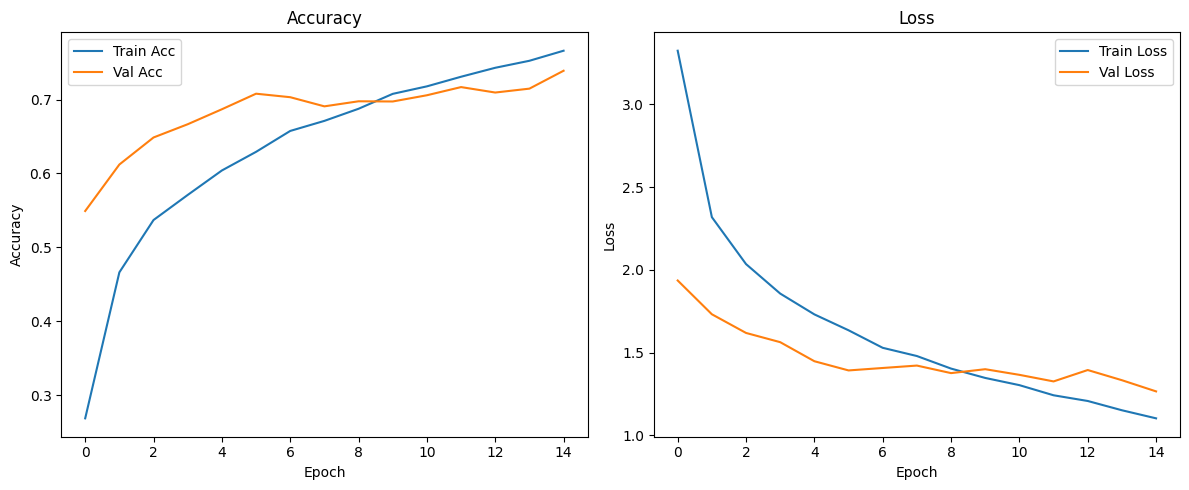

Unfreezing base model for fine-tuning...
Training model...
Epoch 1/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 480s 1s/step - accuracy: 0.6740 - loss: 1.4576 - val_accuracy: 0.7245 - val_loss: 1.3015
Epoch 2/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - accuracy: 0.7270 - loss: 1.2373 - val_accuracy: 0.7176 - val_loss: 1.3305
Epoch 3/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - accuracy: 0.7428 - loss: 1.1983 - val_accuracy: 0.7121 - val_loss: 1.3260
Epoch 4/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 430s 1s/step - accuracy: 0.7625 - loss: 1.1300 - val_accuracy: 0.7139 - val_loss: 1.3043
Epoch 5/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 430s 1s/step - accuracy: 0.7669 - loss: 1.0852 - val_accuracy: 0.7174 - val_loss: 1.2775
Epoch 6/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 434s 1s/step - accuracy: 0.7749 - loss: 1.0783 - val_accuracy: 0.7232 - val_loss: 1.2622
Epoch 7/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - accuracy: 0.7846 - loss: 1.0201 - val_accuracy: 0.7271 - val_loss: 1.2439
Epoch 8/10
416/416 ━━━━━━━━━━━━━━━━━━━

Test accuracy: 0.7318, Test loss: 1.2346
Saving model to mushroom_mobilenet_finetuned.h5...


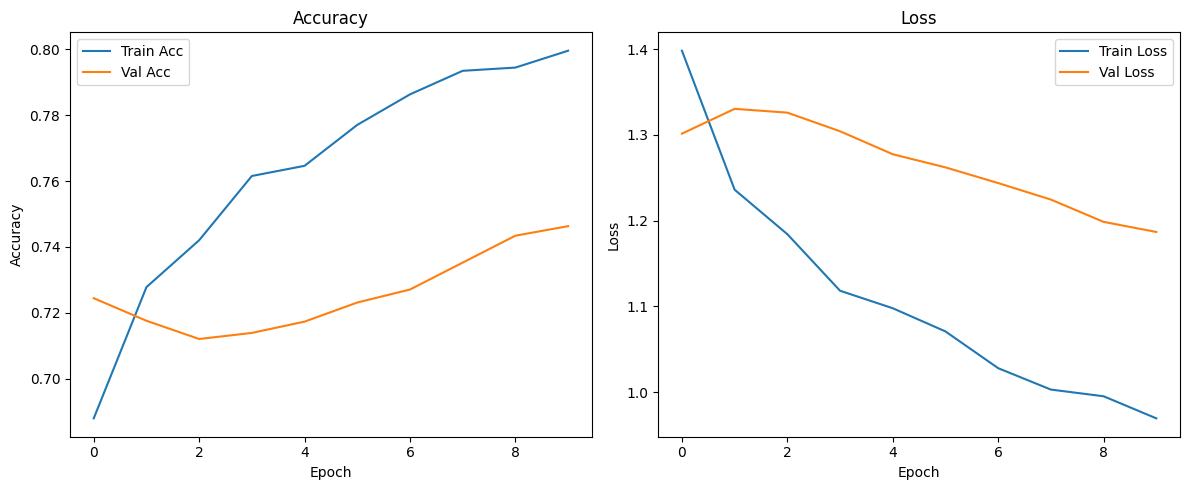

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation, MaxPooling2D,
    GlobalAveragePooling2D, Dense, Dropout, Flatten, GlobalMaxPooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

def mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # More aggressive freezing - freeze more layers initially
    for i, layer in enumerate(base_model.layers):
        layer.trainable = False if i < 136 else True  # Freeze more layers (was 108)
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)  # Increased dropout from 0.3 to 0.5
    
    # Add another dense layer with regularization
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Lower learning rate
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])
    
    return model


def nn_model(input_shape, num_classes):
    """
    Lightweight CNN model built from scratch using Sequential API.
    Designed to be efficient and less prone to overfitting on smaller datasets.
    """
    model = Sequential([
            # Block 1: Reduced filters (32 instead of 64)
        Conv2D(128, (5, 5), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        
        # Block 2: Reduced filters (64 instead of 128)
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        #Flatten(),
        
        # GlobalAveragePooling instead of Flatten - HUGE parameter reduction
        GlobalMaxPooling2D(),
        #Dropout(0.5),
        
        # Dense layer for classification (now only 64*20 + 20 = 1,300 parameters)
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def train_model(model, train_gen, val_gen, epochs=30):
    print('Training model...')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=[early_stop]
    )
    return history

def evaluate_model(model, history, test_gen, model_name):
    print('Evaluating on test set...')
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")
    print(f'Saving model to {model_name}...')
    model.save(model_name)
    # Plot
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')
    plt.tight_layout()
    plt.show()

def main():
    base_dir = '../inaturalist_split'
    train_dir = f'{base_dir}/train'
    test_dir = f'{base_dir}/test'
    val_dir = f'{base_dir}/val'

    img_size = (160, 160)
    batch_size = 32
    epochs = 15

    print('Loading data for MobileNetV2...')


    train_datagen = ImageDataGenerator(
        rescale=1./255,
        # Add mild augmentation even during training for better generalization
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=(160, 160),
        batch_size=32,
        class_mode='categorical'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation
    val_gen = val_datagen.flow_from_directory(
        val_dir,  # Use proper validation directory
        target_size=(160, 160),
        batch_size=32,
        class_mode='categorical'
    )


    # Separate test generator
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=(160, 160),
        batch_size=32,
        class_mode='categorical'
    )


    num_classes = train_gen.num_classes

    # Train with frozen base
    model = mobilenet_model(img_size + (3,), num_classes)
    history = train_model(model, train_gen, val_gen, epochs=epochs)
    evaluate_model(model, history, test_gen, model_name='mushroom_mobilenet_frozen.h5')

    # Fine-tune
    print('Unfreezing base model for fine-tuning...')
    for layer in model.layers:
        layer.trainable = True
    model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    history_finetuned = train_model(model, train_gen, val_gen, epochs=10)
    evaluate_model(model, history_finetuned, test_gen, model_name='mushroom_mobilenet_finetuned.h5')

if __name__ == '__main__':
    main()


In [ ]:
import visualkeras

def mobilenet_model1(image_size, num_classes, freeze_until=100):
    # Reset session
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=image_size)
    for i, layer in enumerate(base_model.layers):
        layer.trainable = False if i < freeze_until else True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.25)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['acc'])
    return model

mobilenet_model = mobilenet_model1((128, 128, 3), 10, freeze_until=100)
mobilenet_model.summary()
visualkeras.layered_view(mobilenet_model, legend = True, spacing = 10)


# MODEL PREDICTIONS

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# === Settings ===
model_path = 'mushroom_mobilenet_finetuned.h5'
data_dir = '../data_augmented'  # same as during training
img_size = (128, 128)

# === Step 1: Load model ===
model = load_model(model_path)

# === Step 2: Get class names from folder structure ===
datagen = ImageDataGenerator(rescale=1./255)
temp_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)
# class_indices: {'Amanita': 0, 'Boletus': 1, ...}
class_indices = temp_gen.class_indices
class_labels = list(class_indices.keys())

# === Step 3: Preprocess and Predict a new image ===
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_image(img_path):
    img_array = preprocess_image(img_path)
    preds = model.predict(img_array)
    class_idx = np.argmax(preds, axis=1)[0]
    label = class_labels[class_idx]
    confidence = preds[0][class_idx]
    return label, confidence

# === Step 4: Predict ===
img_path = '../tests/morel.jpg'
label, confidence = predict_image(img_path)
print(f"Predicted: {label} (Confidence: {confidence:.2f})")


# TESTING

In [ ]:
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

def build_mobilenet_model(input_shape=(128, 128, 3), num_classes=10, freeze_until=100):
    print(f'Building MobileNetV2 model with input shape {input_shape}...')
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    print(f'Freezing first {freeze_until} layers of the base model...')
    for i, layer in enumerate(base_model.layers):
        layer.trainable = False if i < freeze_until else True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def train_model(model, train_gen, val_data, val_labels, epochs=30):
    print('Training model...')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=(val_data, val_labels),
        callbacks=[early_stop]
    )
    return history

def evaluate_model(model, history, test_data, test_labels, model_name):
    print('Evaluating on test set...')
    test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")
    print(f'Saving model to {model_name}...')
    model.save(model_name)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')
    plt.tight_layout()
    plt.show()

def main():
    augmented_dir = '../data_augmented'
    img_size = (128, 128) 
    batch_size = 32  
    epochs = 15
    print('Loading data for EfficientNetB5...')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    train_gen = datagen.flow_from_directory(
        augmented_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=42
    )
    val_test_gen = datagen.flow_from_directory(
        augmented_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=True,
        seed=42
    )
    val_samples = int(0.5 * val_test_gen.samples)
    test_samples = val_test_gen.samples - val_samples
    val_data, val_labels, test_data, test_labels = [], [], [], []
    for i in range(val_test_gen.samples):
        x, y = next(val_test_gen)
        for j in range(x.shape[0]):
            if i * batch_size + j < val_samples:
                val_data.append(x[j])
                val_labels.append(y[j])
            else:
                test_data.append(x[j])
                test_labels.append(y[j])
            if len(val_data) >= val_samples and len(test_data) >= test_samples:
                break
        if len(val_data) >= val_samples and len(test_data) >= test_samples:
            break
    val_data = np.array(val_data)
    val_labels = np.array(val_labels)
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    num_classes = train_gen.num_classes

    # Train with frozen base
    model = build_mobilenet_model(img_size + (3,), num_classes, freeze_until=10)
    history = train_model(model, train_gen, val_data, val_labels, epochs=epochs)
    evaluate_model(model, history, test_data, test_labels, model_name='mushroom_efficientnet_frozen.h5')

    # Fine-tuning
    print('Unfreezing base model for fine-tuning...')
    for layer in model.layers:
        layer.trainable = True
    model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    history_finetuned = train_model(model, train_gen, val_data, val_labels, epochs=10)
    evaluate_model(model, history_finetuned, test_data, test_labels, model_name='mushroom_efficientnet_finetuned.h5')

if __name__ == '__main__':
    main()
